# Import Libraries

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tableone import TableOne
import warnings
from sklearn.model_selection import train_test_split
import joblib
import seaborn as sns
from sklearn.metrics import roc_auc_score

warnings.filterwarnings("ignore")


# Load all data


In [109]:
# Loading original dataset
original_data = pd.read_csv('../preprocessed_data.csv')

# Loading altered dataset
data_altered_complete = pd.read_csv('../data_altered_complete.csv')


# Loading the models for comparison

In [110]:
# Random Forest Original
original_rf_loaded = joblib.load("../original_data_random_forest_model.pkl")

# Random Forest Altered 20% African American
altered_rf_loaded = joblib.load("../altered_rf_model.pkl")

# Random Forest Altered 80% Female

# Bootstrapping Model Performance: What It Shows

This analysis uses bootstrapping to measure the stability and uncertainty of our model’s performance. By repeatedly resampling the test data, we generate confidence intervals (CIs) for AUROC and Accuracy, helping us:

-  **Compare multiple models fairly** → Shows how consistently each model performs across different samples.
-  **Visualize uncertainty** → Narrower distributions mean more reliable models, while wider distributions indicate higher variability.
-  **Identify trade-offs** → If a debiased model has lower AUROC but better fairness, bootstrapping helps justify the trade-off.

**Why It Matters:**
Instead of relying on a single test result, bootstrapping ensures our conclusions hold across different samples, making our evaluation more robust and trustworthy.

In [52]:
# Ensure the same features are used as in training
expected_features = original_rf_loaded.feature_names_in_  # Get the features used during training
print(expected_features)

['Unnamed: 0' 'patient_id' 'age' 'elective_surgery' 'bmi'
 'apache_4a_hospital_death_prob' 'aids' 'cirrhosis' 'diabetes_mellitus'
 'hepatic_failure' 'immunosuppression' 'leukemia' 'lymphoma'
 'solid_tumor_with_metastasis' 'readmission_status' 'gender_F'
 'ethnicity_African American' 'ethnicity_Asian' 'ethnicity_Caucasian'
 'ethnicity_Hispanic' 'ethnicity_Native American' 'age_cat_0-9'
 'age_cat_10-19' 'age_cat_20-29' 'age_cat_30-39' 'age_cat_40-49'
 'age_cat_50-59' 'age_cat_60-69' 'age_cat_70-79' 'age_cat_80-89'
 'bmi_cat_10-14' 'bmi_cat_15-19' 'bmi_cat_20-24' 'bmi_cat_25-29'
 'bmi_cat_30-34' 'bmi_cat_35-39' 'bmi_cat_40-44' 'bmi_cat_>45']


In [53]:
# Ensure the same features are used as in training
expected_features = altered_rf_loaded.feature_names_in_  # Get the features used during training
print(expected_features)

['Unnamed: 0' 'patient_id' 'age' 'elective_surgery' 'bmi'
 'apache_4a_hospital_death_prob' 'aids' 'cirrhosis' 'diabetes_mellitus'
 'hepatic_failure' 'immunosuppression' 'leukemia' 'lymphoma'
 'solid_tumor_with_metastasis' 'readmission_status' 'gender_F'
 'ethnicity_African American' 'ethnicity_Asian' 'ethnicity_Caucasian'
 'ethnicity_Hispanic' 'ethnicity_Native American' 'age_cat_0-9'
 'age_cat_10-19' 'age_cat_20-29' 'age_cat_30-39' 'age_cat_40-49'
 'age_cat_50-59' 'age_cat_60-69' 'age_cat_70-79' 'age_cat_80-89'
 'bmi_cat_10-14' 'bmi_cat_15-19' 'bmi_cat_20-24' 'bmi_cat_25-29'
 'bmi_cat_30-34' 'bmi_cat_35-39' 'bmi_cat_40-44' 'bmi_cat_>45']


Bootstrapping Random Forest...
Bootstrapping Altered Random Forest...


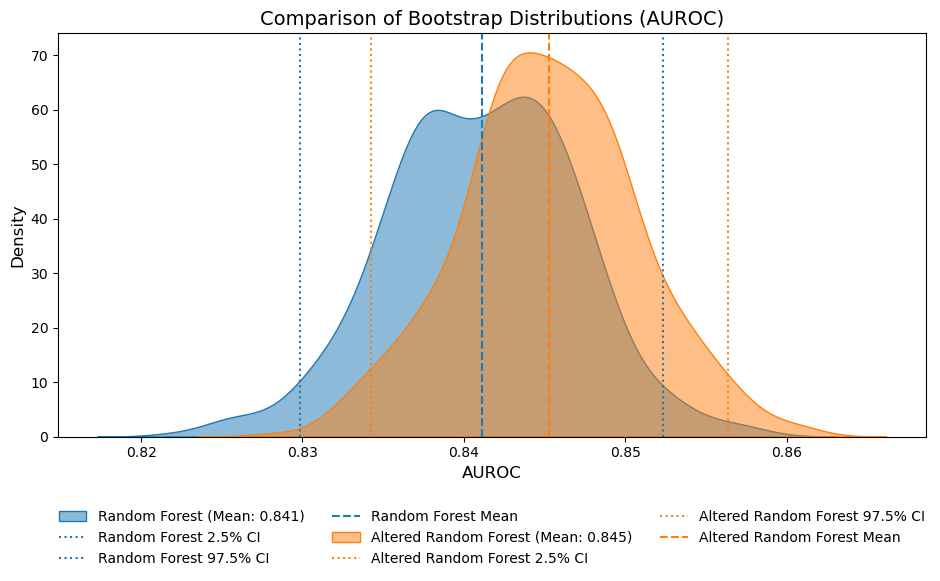

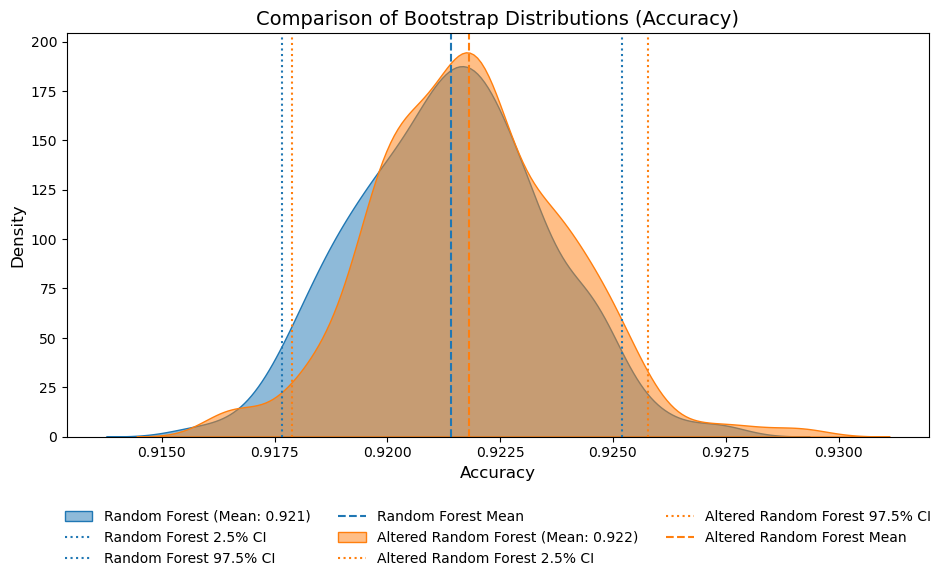

In [111]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import accuracy_score, roc_auc_score

# Drop the 'gender_M' and 'ethnicity_Other' columns
original_data = original_data.drop(columns=['gender_M', 'ethnicity_Other/Unknown'])

# Define your features and target variable
X = original_data.drop('hospital_death', axis=1)  # Features
y = original_data['hospital_death']               # Target variable

# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# **🚀 Compute Bootstrap Distributions for Accuracy & AUROC**
def compute_bootstrap_scores(model, X_test, y_test, n_bootstraps=500):
    """Compute bootstrapped Accuracy and AUROC scores."""
    y_pred_full = model.predict(X_test)
    y_pred_proba_full = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    y_test_np = y_test.to_numpy()

    def bootstrap_metric(metric_func, y_pred, use_proba=False):
        def compute_bootstrap(_):
            indices = np.random.choice(len(y_test_np), len(y_test_np), replace=True)
            return metric_func(y_test_np[indices], y_pred[indices])

        return joblib.Parallel(n_jobs=-1)(
            joblib.delayed(compute_bootstrap)(_) for _ in range(n_bootstraps)
        )

    accuracy_scores = bootstrap_metric(accuracy_score, y_pred_full)
    auroc_scores = bootstrap_metric(roc_auc_score, y_pred_proba_full, use_proba=True) if y_pred_proba_full is not None else None

    return accuracy_scores, auroc_scores

# **🚀 Compute Bootstraps for Each Model**
bootstrapped_results = {}

for model, name in zip([original_rf_loaded, altered_rf_loaded], ["Random Forest", "Altered Random Forest"]):
    print(f"Bootstrapping {name}...")
    accuracy_scores, auroc_scores = compute_bootstrap_scores(model, X_test, y_test)
    bootstrapped_results[name] = {"Accuracy": accuracy_scores, "AUROC": auroc_scores}

# **🚀 Plot Both Accuracy & AUROC**
def plot_bootstrap_comparison(bootstrapped_results, metric_name):
    """Compare the bootstrap distributions of a given metric across multiple models."""
    plt.figure(figsize=(10, 6))
    colors = sns.color_palette("tab10", len(bootstrapped_results))

    for (model_name, scores_dict), color in zip(bootstrapped_results.items(), colors):
        scores = scores_dict[metric_name]
        if scores is None:
            continue  # Skip if metric is not available

        lower_ci = np.percentile(scores, 2.5)
        upper_ci = np.percentile(scores, 97.5)
        mean_value = np.mean(scores)

        # Plot KDE curve
        sns.kdeplot(scores, label=f"{model_name} (Mean: {mean_value:.3f})", fill=True, color=color, alpha=0.5)

        # Add CI and Mean lines
        plt.axvline(lower_ci, color=color, linestyle='dotted', label=f"{model_name} 2.5% CI")
        plt.axvline(upper_ci, color=color, linestyle='dotted', label=f"{model_name} 97.5% CI")
        plt.axvline(mean_value, color=color, linestyle='dashed', label=f"{model_name} Mean")

    # Labels & Formatting
    plt.xlabel(metric_name, fontsize=12)
    plt.ylabel("Density", fontsize=12)
    plt.title(f"Comparison of Bootstrap Distributions ({metric_name})", fontsize=14)
    plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=3, fontsize=10, frameon=False)
    plt.tight_layout()
    plt.show()

# **🚀 Generate Plots**
plot_bootstrap_comparison(bootstrapped_results, "AUROC")
plot_bootstrap_comparison(bootstrapped_results, "Accuracy")


## Assessing Model Fairness: AUROC by Subgroup 


This analysis evaluates model fairness by calculating the AUROC (Area Under the Receiver Operating Characteristic Curve) for different demographic subgroups. Instead of measuring overall performance, we analyze whether the model performs equally well across different groups.

**What This Does**
- Computes AUROC for each subgroup → Ethnicity, Gender, Age, and BMI.
- Identifies disparities in predictive performance → Some groups may have significantly lower AUROC.
- Visualizes results with bar plots → A clear way to compare performance gaps across subgroups.

**Why This Matters**
- If AUROC is lower for certain groups, it suggests the model may be biased or less effective for them.
- Fairer models should have similar AUROC across all subgroups.
- Helps justify debiasing techniques and guides model improvements.


In [112]:
# Same helper function for ethnicity / age / BMI
def calculate_auroc_by_group(data, group_columns, model, X_test, y_test):
    auroc_scores_else = {}
    for group_column in group_columns:
        # Filter the test set for the current group
        group_indices = (X_test[group_column] == 1)
        X_group = X_test[group_indices]
        y_group = y_test[group_indices]
        
        # Calculate AUROC if the group has enough samples
        if len(y_group) > 0:
            y_pred_proba_group = model.predict_proba(X_group)[:, 1]
            auroc_scores_else[group_column] = roc_auc_score(y_group, y_pred_proba_group)
    
    return auroc_scores_else


# Helper function for a single gender column (by default "gender_F")
def calculate_auroc_for_gender(model, X_test, y_test, gender_column='gender_F'):
    auroc_scores_by_gender = {}

    # Females
    female_indices = (X_test[gender_column] == 1)
    X_female = X_test[female_indices]
    y_female = y_test[female_indices]
    if len(y_female) > 0:
        y_pred_proba_female = model.predict_proba(X_female)[:, 1]
        auroc_scores_by_gender['Female'] = roc_auc_score(y_female, y_pred_proba_female)

    # Males
    male_indices = (X_test[gender_column] == 0)
    X_male = X_test[male_indices]
    y_male = y_test[female_indices == False]  # or simply y_test[male_indices]
    if len(y_male) > 0:
        y_pred_proba_male = model.predict_proba(X_male)[:, 1]
        auroc_scores_by_gender['Male'] = roc_auc_score(y_male, y_pred_proba_male)

    return auroc_scores_by_gender

## Using Subgroup Functions

AUROC by Ethnicity: {'ethnicity_African American': np.float64(0.8552287087912087), 'ethnicity_Asian': np.float64(0.8386208291203235), 'ethnicity_Caucasian': np.float64(0.8470792274339771), 'ethnicity_Hispanic': np.float64(0.8318324321388483), 'ethnicity_Native American': np.float64(0.8486764207816839)}
AUROC by Gender: {'Female': np.float64(0.8445934571549354), 'Male': np.float64(0.8452997551591466)}
AUROC by Age: {'age_cat_10-19': np.float64(0.9233082706766917), 'age_cat_20-29': np.float64(0.8676144756277696), 'age_cat_30-39': np.float64(0.9119730597431602), 'age_cat_40-49': np.float64(0.8833369659982564), 'age_cat_50-59': np.float64(0.8693450149925037), 'age_cat_60-69': np.float64(0.8395267205679353), 'age_cat_70-79': np.float64(0.8134194890077244), 'age_cat_80-89': np.float64(0.7726723249554482)}
AUROC by BMI: {'bmi_cat_10-14': np.float64(0.7215277777777778), 'bmi_cat_15-19': np.float64(0.7731023942944473), 'bmi_cat_20-24': np.float64(0.8263417234330995), 'bmi_cat_25-29': np.float64

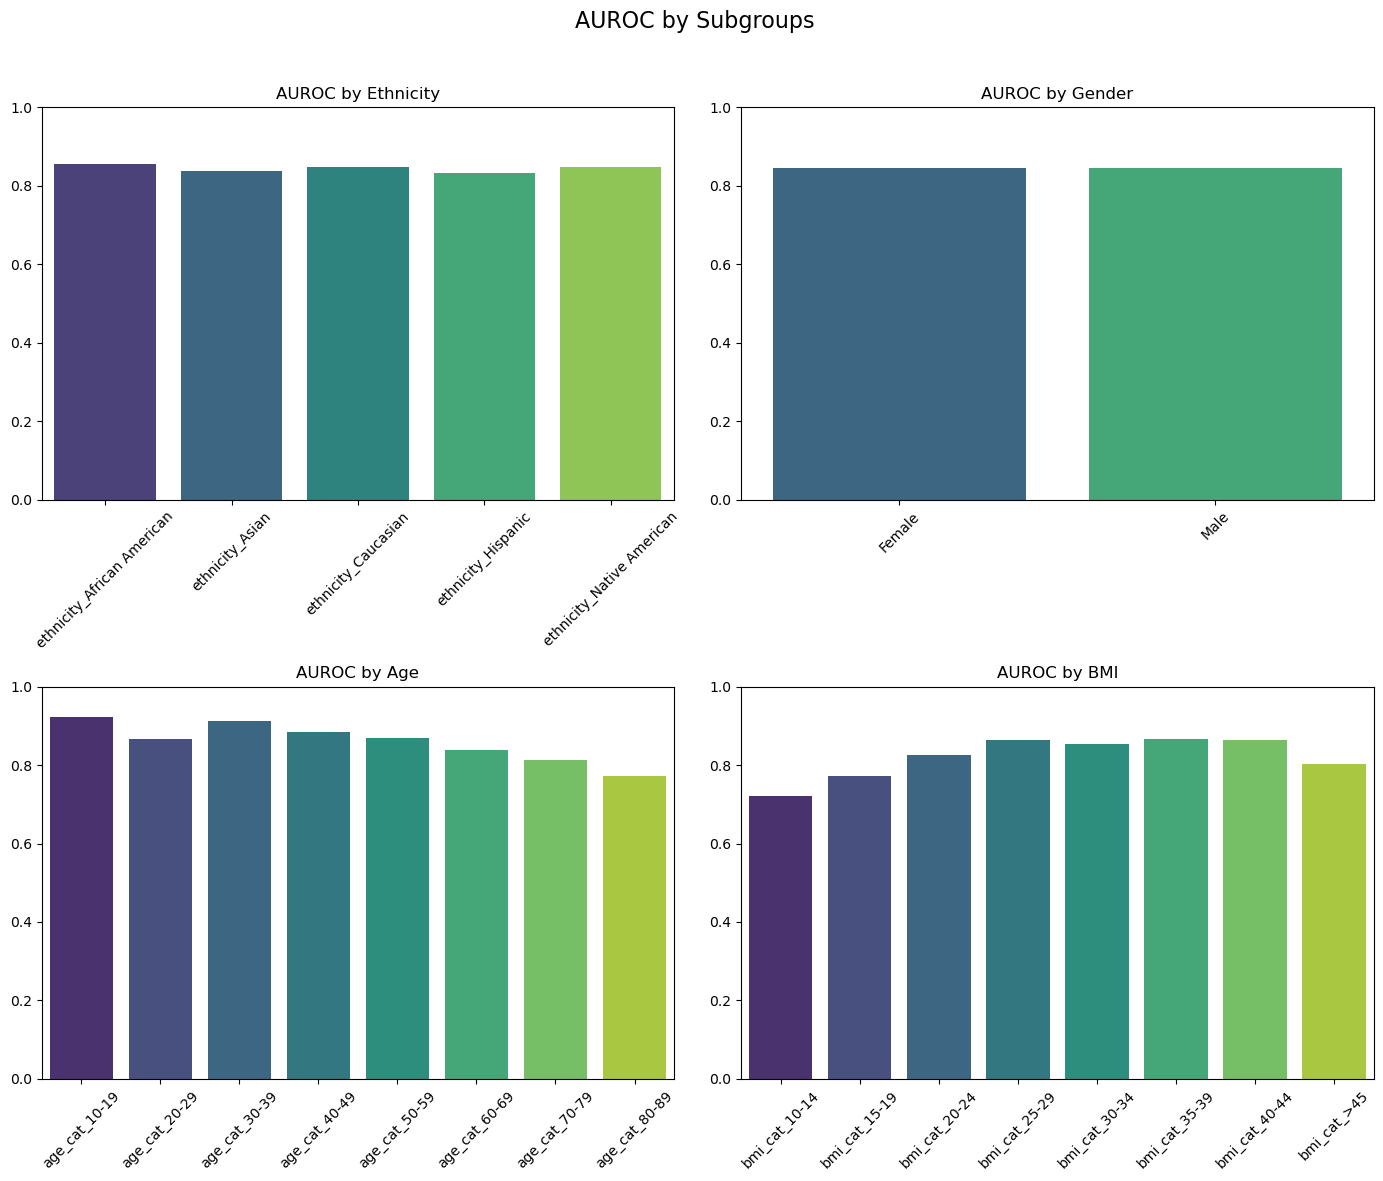

In [113]:
# Choose the model you want to explore
model_of_interest = altered_rf_loaded  # Any model you want to explore
data = data_altered_complete

# Drop the 'gender_M' and 'ethnicity_Other' columns
data = data.drop(columns=['gender_M', 'ethnicity_Other/Unknown'])

# Define your features and target variable
X = data.drop('hospital_death', axis=1)  # Features
y = data['hospital_death']               # Target variable

# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



# Example subgroup columns
ethnicity_columns = [
    'ethnicity_African American',
    'ethnicity_Asian',
    'ethnicity_Caucasian',
    'ethnicity_Hispanic',
    'ethnicity_Native American'
]

age_columns = [
    'age_cat_10-19', 'age_cat_20-29', 'age_cat_30-39',
    'age_cat_40-49', 'age_cat_50-59', 'age_cat_60-69',
    'age_cat_70-79', 'age_cat_80-89'
]

bmi_columns = [
    'bmi_cat_10-14', 'bmi_cat_15-19', 'bmi_cat_20-24', 'bmi_cat_25-29',
    'bmi_cat_30-34', 'bmi_cat_35-39', 'bmi_cat_40-44', 'bmi_cat_>45'
]

data['gender_M'] = 1 - data['gender_F']  # only if "gender_F" exists!

# Now calculate AUROC for each subgroup
auroc_by_ethnicity = calculate_auroc_by_group(
    data, ethnicity_columns, model_of_interest, X_test, y_test
)

# For gender, we have a simpler specialized function:
auroc_by_gender = calculate_auroc_for_gender(
    model_of_interest, X_test, y_test, gender_column='gender_F'
)

auroc_by_age = calculate_auroc_by_group(
    data, age_columns, model_of_interest, X_test, y_test
)

auroc_by_bmi = calculate_auroc_by_group(
    data, bmi_columns,model_of_interest, X_test, y_test
)

print("AUROC by Ethnicity:", auroc_by_ethnicity)
print("AUROC by Gender:", auroc_by_gender)
print("AUROC by Age:", auroc_by_age)
print("AUROC by BMI:", auroc_by_bmi)

# Finally, plot the four sets of results in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('AUROC by Subgroups', fontsize=16)

# 1) Ethnicity
sns.barplot(
    ax=axes[0, 0],
    x=list(auroc_by_ethnicity.keys()),
    y=list(auroc_by_ethnicity.values()),
    palette='viridis'
)
axes[0, 0].set_title('AUROC by Ethnicity')
axes[0, 0].set_ylim(0, 1)
axes[0, 0].tick_params(axis='x', rotation=45)

# 2) Gender
sns.barplot(
    ax=axes[0, 1],
    x=list(auroc_by_gender.keys()),
    y=list(auroc_by_gender.values()),
    palette='viridis'
)
axes[0, 1].set_title('AUROC by Gender')
axes[0, 1].set_ylim(0, 1)
axes[0, 1].tick_params(axis='x', rotation=45)

# 3) Age
sns.barplot(
    ax=axes[1, 0],
    x=list(auroc_by_age.keys()),
    y=list(auroc_by_age.values()),
    palette='viridis'
)
axes[1, 0].set_title('AUROC by Age')
axes[1, 0].set_ylim(0, 1)
axes[1, 0].tick_params(axis='x', rotation=45)

# 4) BMI
sns.barplot(
    ax=axes[1, 1],
    x=list(auroc_by_bmi.keys()),
    y=list(auroc_by_bmi.values()),
    palette='viridis'
)
axes[1, 1].set_title('AUROC by BMI')
axes[1, 1].set_ylim(0, 1)
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Calculating AUROC of Original Data for Model Comparison

In [114]:
import pandas as pd

# Loading original dataset
original_data = pd.read_csv('../preprocessed_data.csv')

# Drop the 'gender_M' and 'ethnicity_Other' columns
original_data = original_data.drop(columns=['gender_M', 'ethnicity_Other/Unknown'])

# Define your features and target variable
X = original_data.drop('hospital_death', axis=1)  # Features
y = original_data['hospital_death']               # Target variable

# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Calculate AUROC for  original data
auroc_by_ethnicity_original = calculate_auroc_by_group(
    original_data, ethnicity_columns, original_rf_loaded, X_test, y_test
)
auroc_by_gender_original = calculate_auroc_for_gender(
    original_rf_loaded, X_test, y_test, gender_column='gender_F'
)
auroc_by_age_original = calculate_auroc_by_group(
    original_data, age_columns, original_rf_loaded, X_test, y_test
)
auroc_by_bmi_original = calculate_auroc_by_group(
    original_data, bmi_columns, original_rf_loaded, X_test, y_test
)

# Create DataFrames for each set of AUROC scores
ethnicity_df = pd.DataFrame({
    'Ethnicity': list(auroc_by_ethnicity.keys()),
    'AUROC_Altered': list(auroc_by_ethnicity.values()),
    'AUROC_Original': list(auroc_by_ethnicity_original.values())
})

gender_df = pd.DataFrame({
    'Gender': list(auroc_by_gender.keys()),
    'AUROC_Altered': list(auroc_by_gender.values()),
    'AUROC_Original': list(auroc_by_gender_original.values())
})

age_df = pd.DataFrame({
    'Age': list(auroc_by_age.keys()),
    'AUROC_Altered': list(auroc_by_age.values()),
    'AUROC_Original': list(auroc_by_age_original.values())
})

bmi_df = pd.DataFrame({
    'BMI': list(auroc_by_bmi.keys()),
    'AUROC_Altered': list(auroc_by_bmi.values()),
    'AUROC_Original': list(auroc_by_bmi_original.values())
})

# Display the DataFrames
print("AUROC by Ethnicity:")
print(ethnicity_df)

print("\nAUROC by Gender:")
print(gender_df)

print("\nAUROC by Age:")
print(age_df)

print("\nAUROC by BMI:")
print(bmi_df)

AUROC by Ethnicity:
                    Ethnicity  AUROC_Altered  AUROC_Original
0  ethnicity_African American       0.855229        0.871244
1             ethnicity_Asian       0.838621        0.844079
2         ethnicity_Caucasian       0.847079        0.836212
3          ethnicity_Hispanic       0.831832        0.879831
4   ethnicity_Native American       0.848676        0.934906

AUROC by Gender:
   Gender  AUROC_Altered  AUROC_Original
0  Female       0.844593        0.830308
1    Male       0.845300        0.851090

AUROC by Age:
             Age  AUROC_Altered  AUROC_Original
0  age_cat_10-19       0.923308        0.904511
1  age_cat_20-29       0.867614        0.885007
2  age_cat_30-39       0.911973        0.900544
3  age_cat_40-49       0.883337        0.877036
4  age_cat_50-59       0.869345        0.872078
5  age_cat_60-69       0.839527        0.834547
6  age_cat_70-79       0.813419        0.811266
7  age_cat_80-89       0.772672        0.765716

AUROC by BMI:
           

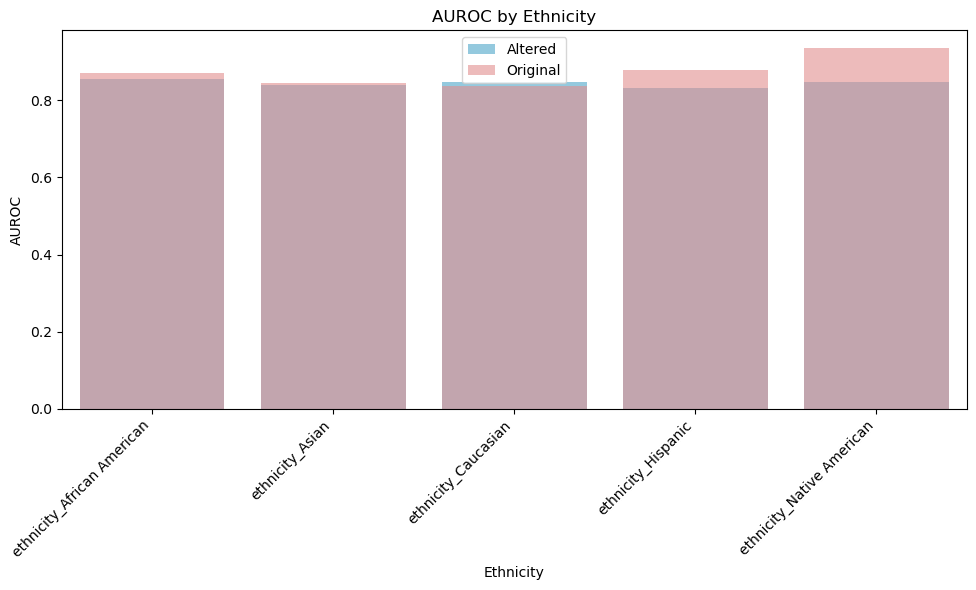

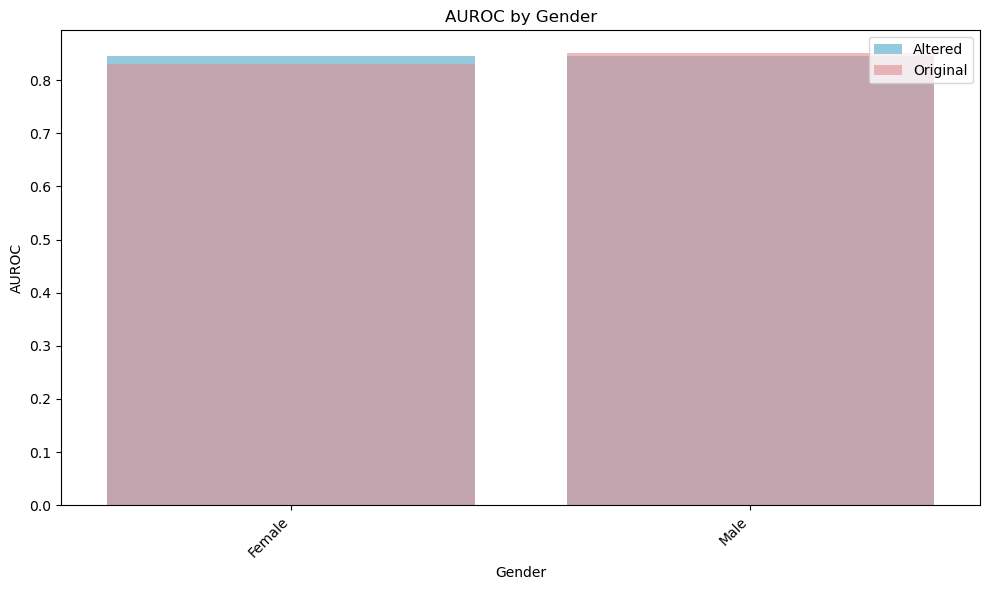

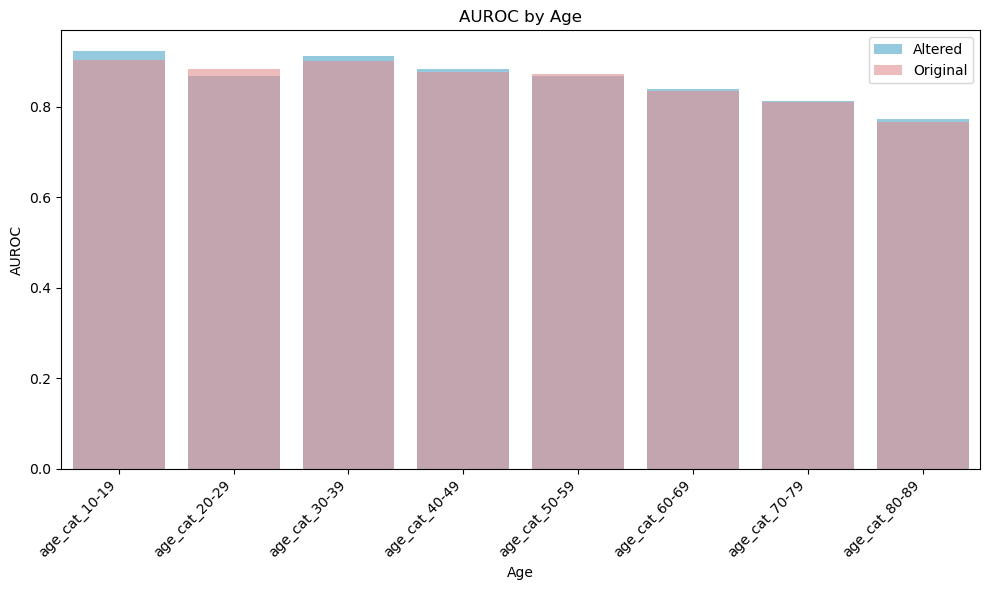

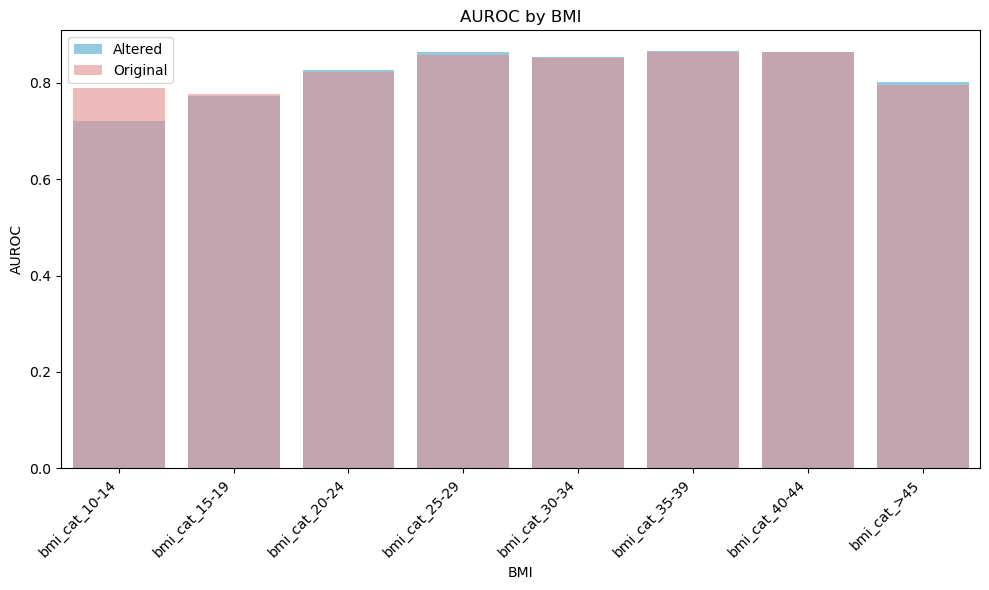

In [115]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_auroc_comparison(df, category, title):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=category, y='AUROC_Altered', data=df, color='skyblue', label='Altered')
    sns.barplot(x=category, y='AUROC_Original', data=df, color='lightcoral', alpha=0.6, label='Original')
    plt.title(title)
    plt.ylabel('AUROC')
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot AUROC comparisons
plot_auroc_comparison(ethnicity_df, 'Ethnicity', 'AUROC by Ethnicity')
plot_auroc_comparison(gender_df, 'Gender', 'AUROC by Gender')
plot_auroc_comparison(age_df, 'Age', 'AUROC by Age')
plot_auroc_comparison(bmi_df, 'BMI', 'AUROC by BMI')